<a href="https://colab.research.google.com/github/JVR27XD/MobileSAM/blob/main/SAMMobile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# Instalar MobileSAM directamente desde GitHub
!pip install git+https://github.com/ChaoningZhang/MobileSAM.git

# Instalar gdown para descargar archivos de Google Drive
!pip install gdown
print("\n--- Instalación completada ---")

  Cloning https://github.com/ChaoningZhang/MobileSAM.git to /tmp/pip-req-build-u0twwf4v
  Running command git clone --filter=blob:none --quiet https://github.com/ChaoningZhang/MobileSAM.git /tmp/pip-req-build-u0twwf4v
  Resolved https://github.com/ChaoningZhang/MobileSAM.git to commit 34bbbfdface3c18e5221aa7de6032d7220c6c6a1
  Preparing metadata (setup.py) ... done

--- Instalación completada ---


In [37]:
# Crear carpeta para los pesos
!mkdir -p weights

# Descargar el archivo con gdown
!gdown --id 1WB3zhHB9Jf5PNbs3eub13Mt4vmhL3VYT -O weights/mobile_sam.pt

# Verificar la descarga
!ls -lh weights/mobile_sam.pt


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1WB3zhHB9Jf5PNbs3eub13Mt4vmhL3VYT
From (redirected): https://drive.google.com/uc?id=1WB3zhHB9Jf5PNbs3eub13Mt4vmhL3VYT&confirm=t&uuid=da551d20-2e7d-45cf-ae58-b58efcc01b26
To: /content/weights/mobile_sam.pt
100% 40.7M/40.7M [00:00<00:00, 48.6MB/s]
-rw-r--r-- 1 root root 39M Jun  8 14:39 weights/mobile_sam.pt


In [38]:
# Paso 3 DEFINITIVO: Descargar la imagen REAL usando la URL RAW
print("--- Intentando descargar la imagen REAL 'MobileSAMv2/test_images/1.jpg' ---")
!wget https://github.com/ChaoningZhang/MobileSAM/blob/master/MobileSAMv2/test_images/1.jpg -O example_image.jpg

# Verificar que la imagen se haya descargado correctamente
print("\n--- Verificación de 'example_image.jpg' (debería ser la IMAGEN REAL) ---")
!ls -lh example_image.jpg

--- Intentando descargar la imagen REAL 'MobileSAMv2/test_images/1.jpg' ---
--2025-06-09 10:09:22--  https://github.com/ChaoningZhang/MobileSAM/blob/master/MobileSAMv2/test_images/1.jpg
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘example_image.jpg’

example_image.jpg       [ <=>                ] 176.24K  --.-KB/s    in 0.02s   

2025-06-09 10:09:22 (7.42 MB/s) - ‘example_image.jpg’ saved [180468]


--- Verificación de 'example_image.jpg' (debería ser la IMAGEN REAL) ---
-rw-r--r-- 1 root root 177K Jun  9 10:09 example_image.jpg


In [39]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


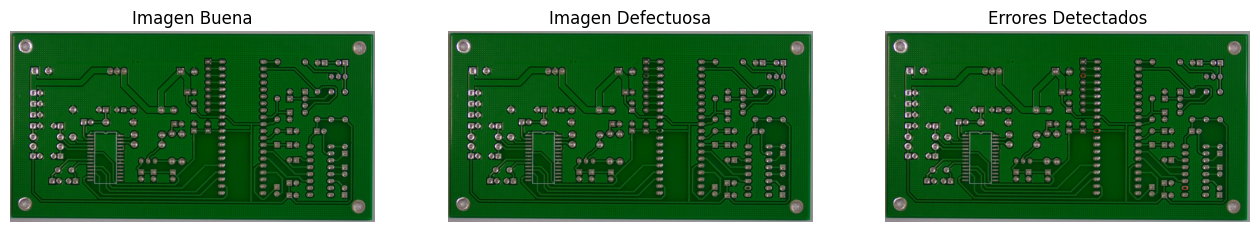

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Leer las imágenes
img_ref = cv2.imread('/content/drive/MyDrive/Colab Notebooks/MobileSAM/01.JPG')
img_def = cv2.imread('/content/drive/MyDrive/Colab Notebooks/MobileSAM/01_missing_hole_01.jpg')


# Redimensionar si no son exactamente iguales (precaución si esto afecta resolución real)
if img_ref.shape != img_def.shape:
    img_def = cv2.resize(img_def, (img_ref.shape[1], img_ref.shape[0]))

# Convertir a escala de grises
gray_ref = cv2.cvtColor(img_ref, cv2.COLOR_BGR2GRAY)
gray_def = cv2.cvtColor(img_def, cv2.COLOR_BGR2GRAY)

# Obtener la diferencia absoluta
diff = cv2.absdiff(gray_ref, gray_def)

# Umbralizar para obtener las zonas diferentes
_, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

# Aplicar morfología para limpiar el ruido
kernel = np.ones((5,5), np.uint8)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

# Encontrar contornos de las diferencias
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujar los contornos sobre la imagen defectuosa
output = img_def.copy()
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 100:  # Ignorar ruido pequeño
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(output, (x, y), (x+w, y+h), (0, 0, 255), 2)

# Visualizar resultados
plt.figure(figsize=(16, 10))
plt.subplot(1, 3, 1)
plt.title("Imagen Buena")
plt.imshow(cv2.cvtColor(img_ref, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Imagen Defectuosa")
plt.imshow(cv2.cvtColor(img_def, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Errores Detectados")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
from mobile_sam import sam_model_registry, SamPredictor
import torch

# Ruta al archivo desde Google Drive
checkpoint = "/content/drive/MyDrive/Colab Notebooks/MobileSAM/mobile_sam.pt"
model_type = "vit_t"

# Cargar el modelo
sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to(device='cuda' if torch.cuda.is_available() else 'cpu')
predictor = SamPredictor(sam)


In [76]:
from mobile_sam import sam_model_registry, SamPredictor
import torch
import numpy as np
import cv2

# Ruta al checkpoint en Google Drive
checkpoint = "/content/drive/MyDrive/Colab Notebooks/MobileSAM/mobile_sam.pt"
model_type = "vit_t"

# Cargar MobileSAM
sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to(device='cuda' if torch.cuda.is_available() else 'cpu')
predictor = SamPredictor(sam)

# Cargar imagen defectuosa (asegúrate que es la misma donde detectaste los contornos)
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/MobileSAM/01_missing_hole_01.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Iniciar predictor con la imagen
predictor.set_image(image_rgb)

# Suponiendo que ya tienes una lista de contornos llamada `contours` (detectados con OpenCV)
input_boxes = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 100:
        x, y, w, h = cv2.boundingRect(cnt)
        input_boxes.append([x, y, x + w, y + h])  # Formato XYXY

input_boxes_np = np.array(input_boxes)

masks = []

for box in input_boxes_np:
    mask_single, _, _ = predictor.predict(
        box=box[None, :],  # añadir dimensión batch
        multimask_output=False
    )
    masks.append(mask_single[0])  # guardar la máscara única


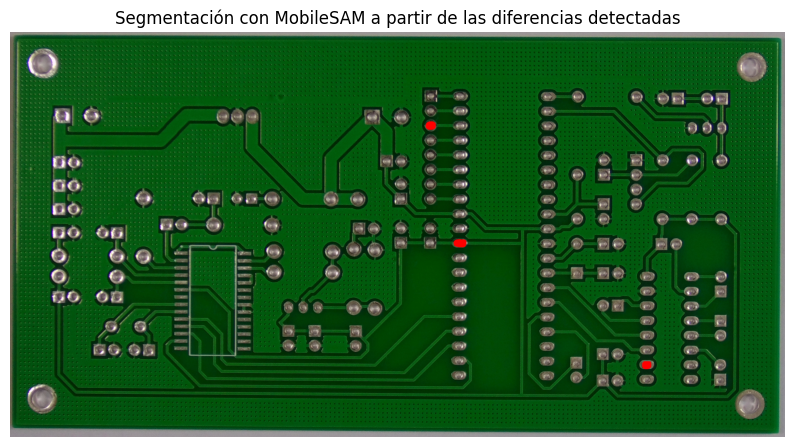

In [101]:
import matplotlib.pyplot as plt

# Crear copia de la imagen para superponer máscaras
image_segmented = image_rgb.copy()

# Colorear las máscaras en rojo semitransparente
for mask in masks:
    image_segmented[mask] = [255, 0, 0]  # rojo

# Mostrar la imagen segmentada
plt.figure(figsize=(10, 6))
plt.imshow(image_segmented)
plt.title("Segmentación con MobileSAM a partir de las diferencias detectadas")
plt.axis('off')
plt.show()

In [102]:
import numpy as np

def compute_iou(mask_pred, mask_gt):
    intersection = np.logical_and(mask_pred, mask_gt).sum()
    union = np.logical_or(mask_pred, mask_gt).sum()
    if union == 0:
        return 0.0
    return intersection / union

In [103]:
import xml.etree.ElementTree as ET
import numpy as np
import cv2

# Ruta a imagen y XML
image_path = "/content/drive/MyDrive/Colab Notebooks/MobileSAM/01_missing_hole_01.jpg"
xml_path = "/content/drive/MyDrive/Colab Notebooks/MobileSAM/01_missing_hole_01.xml"

# Cargar la imagen para obtener su tamaño
image = cv2.imread(image_path)
height, width = image.shape[:2]

# Crear máscara vacía
mask_gt = np.zeros((height, width), dtype=np.uint8)

# Leer el XML y extraer las cajas
tree = ET.parse(xml_path)
root = tree.getroot()

for obj in root.findall('object'):
    bbox = obj.find('bndbox')
    xmin = int(float(bbox.find('xmin').text))
    ymin = int(float(bbox.find('ymin').text))
    xmax = int(float(bbox.find('xmax').text))
    ymax = int(float(bbox.find('ymax').text))

    # Dibujar la caja como una región blanca en la máscara
    cv2.rectangle(mask_gt, (xmin, ymin), (xmax, ymax), 255, thickness=-1)

# Convertir a máscara booleana para IoU
mask_gt_bin = (mask_gt > 0).astype(np.uint8)


In [104]:
if masks[0].shape != mask_gt_bin.shape:
    mask_pred_resized = cv2.resize(masks[0].astype(np.uint8), (mask_gt_bin.shape[1], mask_gt_bin.shape[0]))
    mask_pred_resized = (mask_pred_resized > 0).astype(bool)
else:
    mask_pred_resized = masks[0].astype(bool)

In [105]:
def compute_iou(mask_pred, mask_gt):
    intersection = np.logical_and(mask_pred, mask_gt).sum()
    union = np.logical_or(mask_pred, mask_gt).sum()
    return intersection / union if union != 0 else 0.0

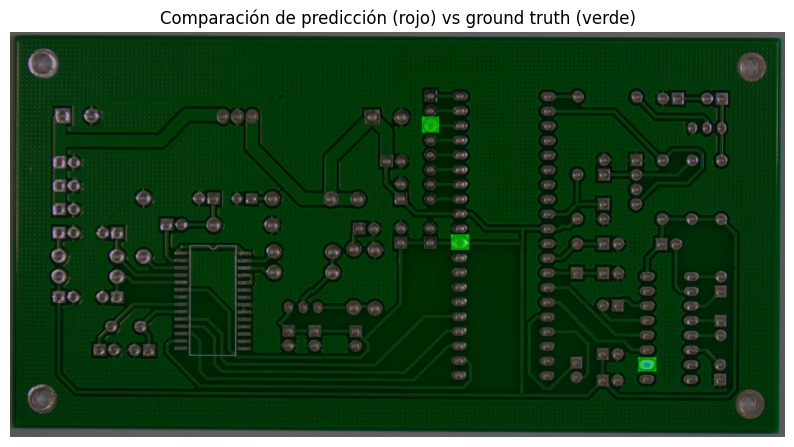

In [106]:
# Asegurar que mask_pred y mask_gt tengan la misma forma
if masks[0].shape != mask_gt_bin.shape:
    mask_pred_resized = cv2.resize(masks[0].astype(np.uint8), (mask_gt_bin.shape[1], mask_gt_bin.shape[0]))
    mask_pred_resized = (mask_pred_resized > 0).astype(bool)
else:
    mask_pred_resized = masks[0].astype(bool)

# Crear overlays
overlay_pred = np.zeros_like(image)
overlay_pred[mask_pred_resized] = [255, 0, 0]  # rojo = predicción SAM

overlay_gt = np.zeros_like(image)
overlay_gt[mask_gt_bin.astype(bool)] = [0, 255, 0]  # verde = ground truth

# Combinar overlays
combined = cv2.addWeighted(image, 0.7, overlay_pred, 0.5, 0)
combined = cv2.addWeighted(combined, 0.9, overlay_gt, 0.5, 0)

# Mostrar
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
plt.title("Comparación de predicción (rojo) vs ground truth (verde)")
plt.axis('off')
plt.show()


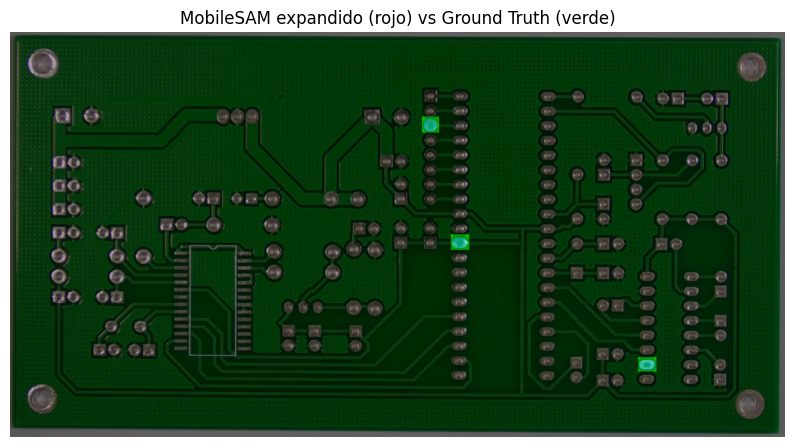

In [129]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# === FUNCIONES ===
def expand_box(box, image_shape, ratio=2.0):
    x1, y1, x2, y2 = box
    cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
    w, h = int((x2 - x1) * ratio), int((y2 - y1) * ratio)
    x1_new = max(0, cx - w // 2)
    y1_new = max(0, cy - h // 2)
    x2_new = min(image_shape[1], cx + w // 2)
    y2_new = min(image_shape[0], cy + h // 2)
    return [x1_new, y1_new, x2_new, y2_new]

# === EXPANDIR TODAS LAS CAJAS ===
input_boxes_expanded = [expand_box(box, image.shape, ratio=2.0) for box in input_boxes]

# === APLICAR MOBILESAM POR CAJA ===
overlay_pred = np.zeros_like(image)
masks = []

for box in input_boxes_expanded:
    mask, _, _ = predictor.predict(
        box=np.array(box)[None, :],
        multimask_output=False
    )
    masks.append(mask[0])
    overlay_pred[mask[0]] = [255, 0, 0]  # rojo = predicción SAM

# === GROUND TRUTH DESDE XML ===
overlay_gt = np.zeros_like(image)
overlay_gt[mask_gt_bin.astype(bool)] = [0, 255, 0]  # verde = GT

# === COMBINAR PARA MOSTRAR ===
combined = cv2.addWeighted(image, 0.7, overlay_pred, 0.5, 0)
combined = cv2.addWeighted(combined, 0.9, overlay_gt, 0.5, 0)

# === VISUALIZAR ===
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
plt.title("MobileSAM expandido (rojo) vs Ground Truth (verde)")
plt.axis('off')
plt.show()


In [135]:
def compute_iou(mask_pred, mask_gt):
    intersection = np.logical_and(mask_pred, mask_gt).sum()
    union = np.logical_or(mask_pred, mask_gt).sum()
    return intersection / union if union != 0 else 0.0

# Combinar todas las máscaras predichas en una sola
combined_mask_pred = np.zeros_like(mask_gt_bin, dtype=bool)

for mask in masks:
    if mask.shape != mask_gt_bin.shape:
        mask = cv2.resize(mask.astype(np.uint8), (mask_gt_bin.shape[1], mask_gt_bin.shape[0]))
        mask = (mask > 0)
    combined_mask_pred = np.logical_or(combined_mask_pred, mask)

# Calcular IoU final
iou_final = compute_iou(combined_mask_pred, mask_gt_bin.astype(bool))
print(f"IoU promedio de todas las máscaras MobileSAM: {iou_final:.4f}")


IoU promedio de todas las máscaras MobileSAM: 0.5093


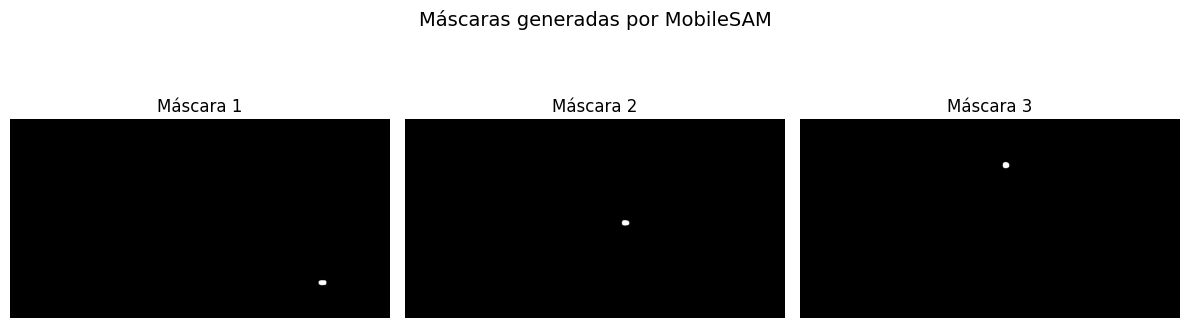

In [136]:
import matplotlib.pyplot as plt

# Asegúrate de haber ejecutado previamente algo como:
# masks, scores, logits = predictor.predict(box=input_boxes_np, multimask_output=False)

# Visualizar cada máscara
plt.figure(figsize=(12, 4))

for i, mask in enumerate(masks):
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Máscara {i+1}')
    plt.axis('off')

plt.suptitle("Máscaras generadas por MobileSAM", fontsize=14)
plt.tight_layout()
plt.show()


In [131]:
def compute_metrics(mask_pred, mask_gt):
    mask_pred = mask_pred.astype(bool)
    mask_gt = mask_gt.astype(bool)

    tp = np.logical_and(mask_pred, mask_gt).sum()
    fp = np.logical_and(mask_pred, np.logical_not(mask_gt)).sum()
    fn = np.logical_and(np.logical_not(mask_pred), mask_gt).sum()

    iou = tp / (tp + fp + fn) if (tp + fp + fn) != 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0.0

    return {
        'IoU': round(iou, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-score': round(f1, 4)
    }

# Asegurarse que las máscaras estén alineadas
if combined_mask_pred.shape != mask_gt_bin.shape:
    combined_mask_pred = cv2.resize(combined_mask_pred.astype(np.uint8), (mask_gt_bin.shape[1], mask_gt_bin.shape[0]))
    combined_mask_pred = (combined_mask_pred > 0)

# Calcular métricas
metrics = compute_metrics(combined_mask_pred, mask_gt_bin)
print("📊 Métricas de evaluación MobileSAM vs Ground Truth:")
for k, v in metrics.items():
    print(f"{k}: {v}")


📊 Métricas de evaluación MobileSAM vs Ground Truth:
IoU: 0.5093
Precision: 1.0
Recall: 0.5093
F1-score: 0.6749


In [114]:
for i, box in enumerate(input_boxes):
    print(f"Caja {i}: {box}")



Caja 0: [2478, 1294, 2506, 1316]
Caja 1: [1744, 815, 1780, 843]
Caja 2: [1633, 357, 1660, 382]


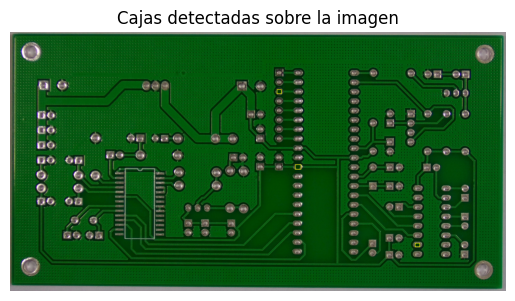

In [133]:
img_debug = image.copy()
for box in input_boxes:
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img_debug, (x1, y1), (x2, y2), (0, 255, 255), 2)

plt.imshow(cv2.cvtColor(img_debug, cv2.COLOR_BGR2RGB))
plt.title("Cajas detectadas sobre la imagen")
plt.axis("off")
plt.show()


In [123]:
for i, box in enumerate(input_boxes):
    x1, y1, x2, y2 = map(int, box)
    print(f"Caja {i}: tamaño {(x2-x1)}x{(y2-y1)}")

Caja 0: tamaño 28x22
Caja 1: tamaño 36x28
Caja 2: tamaño 27x25
